# Multivariate Time Series Forecasting

In [1]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# connecting to the data server
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

In [3]:
jena_climate = pd.read_csv(csv_path)

In [4]:
jena_climate.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [5]:
jena_climate = jena_climate[5::6]
jena_climate.shape

(70091, 15)

In [6]:
jena_climate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70091 entries, 5 to 420545
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date Time        70091 non-null  object 
 1   p (mbar)         70091 non-null  float64
 2   T (degC)         70091 non-null  float64
 3   Tpot (K)         70091 non-null  float64
 4   Tdew (degC)      70091 non-null  float64
 5   rh (%)           70091 non-null  float64
 6   VPmax (mbar)     70091 non-null  float64
 7   VPact (mbar)     70091 non-null  float64
 8   VPdef (mbar)     70091 non-null  float64
 9   sh (g/kg)        70091 non-null  float64
 10  H2OC (mmol/mol)  70091 non-null  float64
 11  rho (g/m**3)     70091 non-null  float64
 12  wv (m/s)         70091 non-null  float64
 13  max. wv (m/s)    70091 non-null  float64
 14  wd (deg)         70091 non-null  float64
dtypes: float64(14), object(1)
memory usage: 8.0+ MB


In [7]:
# formatting to a datetime index
jena_climate.index = pd.to_datetime(jena_climate['Date Time'], format='%d.%m.%Y %H:%M:%S')
jena_climate.drop(['Date Time'], axis = 1, inplace = True)
jena_climate.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
2009-01-01 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
2009-01-01 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
2009-01-01 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
2009-01-01 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


In [8]:
jena_climate = jena_climate.iloc[:, [0, 1, 3]]

In [9]:
# processing the datetime feature
seconds_stamps = jena_climate.index.map(pd.Timestamp.timestamp)

In [10]:
day = 60*60*24
year = 365.2425*day

jena_climate['Day Sin'] = np.sin(seconds_stamps * (2* np.pi / day))
jena_climate['Day Cos'] = np.cos(seconds_stamps * (2* np.pi / day))
jena_climate['Year Sin'] = np.sin(seconds_stamps * (2 * np.pi / year))
jena_climate['Year Cos'] = np.cos(seconds_stamps * (2 * np.pi / year))

In [11]:
jena_climate.head()

,p (mbar),T (degC),Tdew (degC),Day Sin,Day Cos,Year Sin,Year Cos
Date Time,,,,,,,
2009-01-01 01:00:00,996.50,-8.05,-8.78,0.258819,0.965926,0.010049,0.999950
2009-01-01 02:00:00,996.62,-8.88,-9.77,0.500000,0.866025,0.010766,0.999942
2009-01-01 03:00:00,996.84,-8.81,-9.66,0.707107,0.707107,0.011483,0.999934
2009-01-01 04:00:00,996.99,-9.05,-10.02,0.866025,0.500000,0.012199,0.999926
2009-01-01 05:00:00,997.46,-9.63,-10.65,0.965926,0.258819,0.012916,0.999917


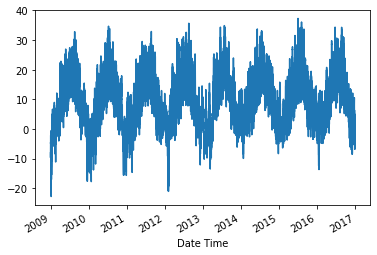

In [12]:
_ = jena_climate['T (degC)'].plot()

In [13]:
jena_climate.to_numpy().shape

(70091, 7)

In [14]:
def generateWindow(df, targets, size = 5):
    df_numpy = df.to_numpy()
    y_idx = [list(jena_climate.columns).index(target) for target in targets]
    X, y = [], []
    for idx in range(len(df_numpy) - size):
        X.append(df_numpy[idx : idx + size])
        y.append([df_numpy[idx + size][i] for i in y_idx])
    return np.array(X), np.array(y)

In [15]:
X, y = generateWindow(jena_climate, ['T (degC)'])
X.shape, y.shape

((70086, 5, 7), (70086, 1))

In [16]:
X_train, y_train = X[:60000], y[:60000]
X_val, y_val = X[60000:65000], y[60000:65000]
X_test, y_test = X[65000:], y[65000:]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((60000, 5, 7), (60000, 1), (5000, 5, 7), (5000, 1), (5086, 5, 7), (5086, 1))

In [17]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.InputLayer((5, 7)))
model.add(tf.keras.layers.LSTM(64))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(8, 'relu'))
model.add(tf.keras.layers.Dense(1, 'linear'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                18432     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 18,961
Trainable params: 18,961
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.compile(loss = 'MeanSquaredError', optimizer = 'adam', metrics = ['MeanSquaredError'])
model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=10)

Epoch 1/10
1875/1875 [==============================] - 15s 7ms/step - loss: 39.6302 - mean_squared_error: 39.6302 - val_loss: 2.5435 - val_mean_squared_error: 2.5435
Epoch 2/10
1875/1875 [==============================] - 12s 6ms/step - loss: 18.1470 - mean_squared_error: 18.1470 - val_loss: 2.0956 - val_mean_squared_error: 2.0956
Epoch 3/10
1875/1875 [==============================] - 11s 6ms/step - loss: 13.7608 - mean_squared_error: 13.7608 - val_loss: 1.8213 - val_mean_squared_error: 1.8213
Epoch 4/10
1875/1875 [==============================] - 11s 6ms/step - loss: 10.9139 - mean_squared_error: 10.9139 - val_loss: 1.0436 - val_mean_squared_error: 1.0436
Epoch 5/10
1875/1875 [==============================] - 11s 6ms/step - loss: 8.4187 - mean_squared_error: 8.4187 - val_loss: 1.1154 - val_mean_squared_error: 1.1154
Epoch 6/10
1875/1875 [==============================] - 11s 6ms/step - loss: 7.8117 - mean_squared_error: 7.8117 - val_loss: 1.1329 - val_mean_squared_error: 1.1329
Ep

In [19]:
def plot_preds(model, X, y, stamps = 100):
    predictions = model.predict(X)
    plt.plot(predictions[:stamps], label = 'Predictions')
    plt.plot(y[:stamps], label = 'Actuals')
    plt.xlabel('Time Stamp')
    plt.ylabel('Temperature')
    plt.legend(loc = 'best')
    return None

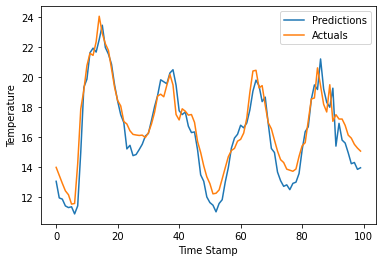

In [20]:
plot_preds(model, X_test, y_test)